In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('/home/fractaluser/Downloads/prototype')
from keras.layers import Input, Dense
from keras.models import Model
from keras import callbacks
import datetime
from scipy import linalg, dot

In [61]:
sample_data = pd.read_csv('sample_simulated_transaction_history.csv')

In [62]:
pd.set_option('display.max_columns', None)

In [63]:
sample_data.head()

,id,date,purchaseamount,dept,category,chain,purchasequantity,company,brand,productsize,productmeasure
0,Donor_1,2015-03-04,203.174075,Sports,Sports,site_1,1,Company1,Brand3,x,xx
1,Donor_1,2016-04-17,300.639489,Sports,Sports,site_1,1,Company1,Brand1,x,xx
2,Donor_1,2015-04-06,374.096413,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand1,x,xx
3,Donor_1,2015-09-04,348.347601,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand3,x,xx
4,Donor_1,2016-03-08,287.477333,Women Apparel,Dresses/Jumpsuits,site_1,1,Company1,Brand3,x,xx


In [64]:
sample_data.shape

(939512, 11)

In [65]:
sample_data.date = pd.to_datetime(sample_data.date)

In [66]:
def name_trunc(x):
    x = "_".join(x.split("_", 2)[:2])
    return x

In [67]:
sample_data.id = sample_data.id.map(lambda x:name_trunc(x))

In [68]:
df = []
depts = []
for i in sample_data.dept.unique():
    df.append(sample_data[(sample_data.dept == i)].reset_index(drop = True)[['id','date', 'purchaseamount']])
    depts.append(i)

In [69]:
sample_data.isnull().values.any()

False

In [70]:
def obtain_encoding(dataframe, depts, sample_data, pre_end_date, pre_start_date, EPOCHS, BATCH_SIZE, DIM):
    complete_data = pd.DataFrame({'date':pd.date_range(sample_data.date.min(), sample_data.date.max())})
    complete_data.set_index('date', inplace = True)
    for i in df[0].id.unique():
        specific_donor = df[0][(df[0].id == i)].reset_index(drop = True).groupby(['date']).max().drop(labels = ['id'], axis = 1).reindex(pd.date_range(sample_data.date.min(), sample_data.date.max()), fill_value = 0)
        complete_data[i] = pd.DataFrame({i:specific_donor.purchaseamount})

    xtrain = complete_data[pre_start_date:pre_end_date]
    xtrain1 = xtrain.values
    x_train = xtrain1.T

    encoding_dim = DIM
    input_mat = Input(shape=(x_train.shape[1],))
    encoded = Dense(encoding_dim, activation='linear')(input_mat)
    decoded = Dense(x_train.shape[1], activation='linear')(encoded)

    autoencoder = Model(input_mat, decoded)
    encoder = Model(input_mat, encoded)

    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))

    autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae'])

    history = autoencoder.fit(x_train, x_train, epochs=EPOCHS, verbose = 1, batch_size=BATCH_SIZE, shuffle=True,
                   callbacks = [callbacks.EarlyStopping(monitor='loss', patience=10, mode='auto')])

    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    plt.savefig('performance-%s.png' % depts)

    encoded_mat = encoder.predict(x_train)
    decoded_mat = decoder.predict(encoded_mat)

    new_df = pd.DataFrame(encoded_mat)
    new_df[new_df<0] = 0
    new_df.insert(loc=0, column='id', value=complete_data.columns.values)

    original = pd.DataFrame(x_train)
    original.insert(loc = 0, column = 'id', value = complete_data.columns.values)

    comparison = pd.DataFrame(decoded_mat)
    comparison[comparison<0] = 0
    comparison.insert(loc = 0, column = 'id', value = complete_data.columns.values)
    score = dot(x_train,decoded_mat.T)/linalg.norm(x_train)/linalg.norm(decoded_mat)
    

    return new_df, original, comparison, np.linalg.norm(score,ord=2)

Epoch 1/500
2617/2617 [==============================] - 1s 214us/step - loss: 602.2551 - mean_absolute_error: 8.2564
Epoch 2/500
2617/2617 [==============================] - 0s 30us/step - loss: 513.6783 - mean_absolute_error: 7.9987
Epoch 3/500
2617/2617 [==============================] - 0s 26us/step - loss: 467.3091 - mean_absolute_error: 7.7755
Epoch 4/500
2617/2617 [==============================] - 0s 28us/step - loss: 427.9703 - mean_absolute_error: 7.5645
Epoch 5/500
2617/2617 [==============================] - 0s 29us/step - loss: 397.4326 - mean_absolute_error: 7.3667
Epoch 6/500
2617/2617 [==============================] - 0s 28us/step - loss: 373.2680 - mean_absolute_error: 7.1743
Epoch 7/500
2617/2617 [==============================] - 0s 32us/step - loss: 356.3657 - mean_absolute_error: 6.9892
Epoch 8/500
2617/2617 [==============================] - 0s 25us/step - loss: 345.3068 - mean_absolute_error: 6.8163
Epoch 9/500
2617/2617 [==============================] - 0s 25u

2617/2617 [==============================] - 0s 30us/step - loss: 209.5749 - mean_absolute_error: 4.1304
Epoch 71/500
2617/2617 [==============================] - 0s 31us/step - loss: 209.1967 - mean_absolute_error: 4.1325
Epoch 72/500
2617/2617 [==============================] - 0s 30us/step - loss: 208.8177 - mean_absolute_error: 4.1348
Epoch 73/500
2617/2617 [==============================] - 0s 29us/step - loss: 208.4561 - mean_absolute_error: 4.1370
Epoch 74/500
2617/2617 [==============================] - 0s 30us/step - loss: 208.1077 - mean_absolute_error: 4.1398
Epoch 75/500
2617/2617 [==============================] - 0s 31us/step - loss: 207.7665 - mean_absolute_error: 4.1427
Epoch 76/500
2617/2617 [==============================] - 0s 29us/step - loss: 207.4305 - mean_absolute_error: 4.1453
Epoch 77/500
2617/2617 [==============================] - 0s 30us/step - loss: 207.0974 - mean_absolute_error: 4.1479
Epoch 78/500
2617/2617 [==============================] - 0s 31us/ste

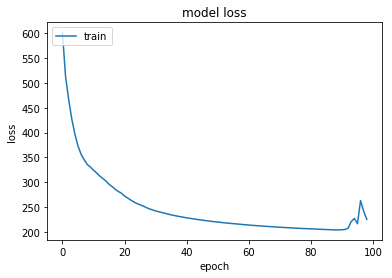

Epoch 1/500
2617/2617 [==============================] - 1s 285us/step - loss: 620.0234 - mean_absolute_error: 8.2469
Epoch 2/500
2617/2617 [==============================] - 0s 68us/step - loss: 539.1859 - mean_absolute_error: 7.9965
Epoch 3/500
2617/2617 [==============================] - 0s 72us/step - loss: 497.1969 - mean_absolute_error: 7.7913
Epoch 4/500
2617/2617 [==============================] - 0s 85us/step - loss: 449.3447 - mean_absolute_error: 7.5946
Epoch 5/500
2617/2617 [==============================] - 0s 112us/step - loss: 418.9709 - mean_absolute_error: 7.4299
Epoch 6/500
2617/2617 [==============================] - 0s 74us/step - loss: 389.6701 - mean_absolute_error: 7.2632
Epoch 7/500
2617/2617 [==============================] - 0s 79us/step - loss: 371.5621 - mean_absolute_error: 7.1065
Epoch 8/500
2617/2617 [==============================] - 0s 76us/step - loss: 357.0517 - mean_absolute_error: 6.9546
Epoch 9/500
2617/2617 [==============================] - 0s 75

2617/2617 [==============================] - 0s 84us/step - loss: 213.1019 - mean_absolute_error: 4.1266
Epoch 71/500
2617/2617 [==============================] - 0s 82us/step - loss: 212.6239 - mean_absolute_error: 4.1276
Epoch 72/500
2617/2617 [==============================] - 0s 80us/step - loss: 212.1639 - mean_absolute_error: 4.1244
Epoch 73/500
2617/2617 [==============================] - 0s 111us/step - loss: 211.7597 - mean_absolute_error: 4.1274
Epoch 74/500
2617/2617 [==============================] - 0s 98us/step - loss: 211.7245 - mean_absolute_error: 4.1350
Epoch 75/500
2617/2617 [==============================] - 0s 90us/step - loss: 211.1973 - mean_absolute_error: 4.1381
Epoch 76/500
2617/2617 [==============================] - 0s 83us/step - loss: 210.7082 - mean_absolute_error: 4.1313
Epoch 77/500
2617/2617 [==============================] - 0s 70us/step - loss: 210.2040 - mean_absolute_error: 4.1312
Epoch 78/500
2617/2617 [==============================] - 0s 71us/st

2617/2617 [==============================] - 0s 73us/step - loss: 197.4013 - mean_absolute_error: 4.1507
Epoch 139/500
2617/2617 [==============================] - 0s 73us/step - loss: 197.3245 - mean_absolute_error: 4.1501
Epoch 140/500
2617/2617 [==============================] - 0s 73us/step - loss: 197.2195 - mean_absolute_error: 4.1465
Epoch 141/500
2617/2617 [==============================] - 0s 126us/step - loss: 197.0975 - mean_absolute_error: 4.1438
Epoch 142/500
2617/2617 [==============================] - 0s 96us/step - loss: 197.0800 - mean_absolute_error: 4.1424
Epoch 143/500
2617/2617 [==============================] - 0s 88us/step - loss: 196.8574 - mean_absolute_error: 4.1354
Epoch 144/500
2617/2617 [==============================] - 0s 68us/step - loss: 196.6667 - mean_absolute_error: 4.1286
Epoch 145/500
2617/2617 [==============================] - 0s 76us/step - loss: 196.7078 - mean_absolute_error: 4.1278
Epoch 146/500
2617/2617 [==============================] - 0s

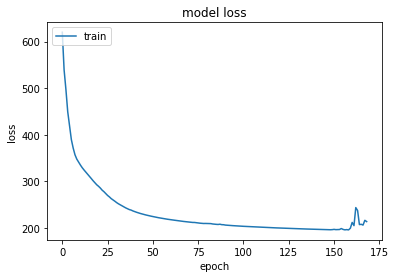

Epoch 1/500
2617/2617 [==============================] - 1s 454us/step - loss: 614.9590 - mean_absolute_error: 8.1352
Epoch 2/500
2617/2617 [==============================] - 0s 82us/step - loss: 523.7891 - mean_absolute_error: 7.8372
Epoch 3/500
2617/2617 [==============================] - 0s 94us/step - loss: 486.1160 - mean_absolute_error: 7.6351
Epoch 4/500
2617/2617 [==============================] - 0s 66us/step - loss: 440.1560 - mean_absolute_error: 7.4157
Epoch 5/500
2617/2617 [==============================] - 0s 88us/step - loss: 402.8010 - mean_absolute_error: 7.2082
Epoch 6/500
2617/2617 [==============================] - 0s 91us/step - loss: 373.7002 - mean_absolute_error: 7.0117
Epoch 7/500
2617/2617 [==============================] - 0s 71us/step - loss: 352.5110 - mean_absolute_error: 6.8218
Epoch 8/500
2617/2617 [==============================] - 0s 86us/step - loss: 342.0249 - mean_absolute_error: 6.6561
Epoch 9/500
2617/2617 [==============================] - 0s 86u

2617/2617 [==============================] - 0s 88us/step - loss: 207.5673 - mean_absolute_error: 4.1458
Epoch 71/500
2617/2617 [==============================] - 0s 78us/step - loss: 207.3949 - mean_absolute_error: 4.1525
Epoch 72/500
2617/2617 [==============================] - 0s 75us/step - loss: 207.4675 - mean_absolute_error: 4.1680
Epoch 73/500
2617/2617 [==============================] - 0s 71us/step - loss: 208.6570 - mean_absolute_error: 4.1870
Epoch 74/500
2617/2617 [==============================] - 0s 58us/step - loss: 207.1131 - mean_absolute_error: 4.1815
Epoch 75/500
2617/2617 [==============================] - 0s 59us/step - loss: 207.1099 - mean_absolute_error: 4.1815
Epoch 76/500
2617/2617 [==============================] - 0s 75us/step - loss: 206.3136 - mean_absolute_error: 4.1849
Epoch 77/500
2617/2617 [==============================] - 0s 87us/step - loss: 205.4969 - mean_absolute_error: 4.1727
Epoch 78/500
2617/2617 [==============================] - 0s 84us/ste

2617/2617 [==============================] - 0s 67us/step - loss: 205.8251 - mean_absolute_error: 4.1697
Epoch 139/500
2617/2617 [==============================] - 0s 77us/step - loss: 197.0678 - mean_absolute_error: 4.1102
Epoch 140/500
2617/2617 [==============================] - 0s 80us/step - loss: 202.1785 - mean_absolute_error: 4.1396
Epoch 141/500
2617/2617 [==============================] - 0s 74us/step - loss: 199.6681 - mean_absolute_error: 4.1109
Epoch 142/500
2617/2617 [==============================] - 0s 79us/step - loss: 196.1789 - mean_absolute_error: 4.0752
Epoch 143/500
2617/2617 [==============================] - 0s 70us/step - loss: 196.2409 - mean_absolute_error: 4.0650
Epoch 144/500
2617/2617 [==============================] - 0s 74us/step - loss: 195.2257 - mean_absolute_error: 4.0481
Epoch 145/500
2617/2617 [==============================] - ETA: 0s - loss: 195.1813 - mean_absolute_error: 4.046 - 0s 90us/step - loss: 194.9907 - mean_absolute_error: 4.0415
Epoch 

2617/2617 [==============================] - 0s 66us/step - loss: 190.1582 - mean_absolute_error: 3.6374
Epoch 207/500
2617/2617 [==============================] - 0s 57us/step - loss: 190.1405 - mean_absolute_error: 3.6348
Epoch 208/500
2617/2617 [==============================] - 0s 67us/step - loss: 190.2640 - mean_absolute_error: 3.6272
Epoch 209/500
2617/2617 [==============================] - 0s 65us/step - loss: 189.6463 - mean_absolute_error: 3.6136
Epoch 210/500
2617/2617 [==============================] - 0s 56us/step - loss: 189.6150 - mean_absolute_error: 3.6027
Epoch 211/500
2617/2617 [==============================] - 0s 83us/step - loss: 189.7956 - mean_absolute_error: 3.6015
Epoch 212/500
2617/2617 [==============================] - 0s 77us/step - loss: 189.6187 - mean_absolute_error: 3.5900
Epoch 213/500
2617/2617 [==============================] - 0s 92us/step - loss: 189.7162 - mean_absolute_error: 3.5944
Epoch 214/500
2617/2617 [==============================] - 0s 

2617/2617 [==============================] - 0s 108us/step - loss: 186.4567 - mean_absolute_error: 3.1959
Epoch 275/500
2617/2617 [==============================] - 0s 79us/step - loss: 186.4221 - mean_absolute_error: 3.1922
Epoch 276/500
2617/2617 [==============================] - 0s 78us/step - loss: 186.3917 - mean_absolute_error: 3.1870
Epoch 277/500
2617/2617 [==============================] - 0s 76us/step - loss: 186.3690 - mean_absolute_error: 3.1828
Epoch 278/500
2617/2617 [==============================] - 0s 97us/step - loss: 186.4245 - mean_absolute_error: 3.1790
Epoch 279/500
2617/2617 [==============================] - 0s 75us/step - loss: 186.4071 - mean_absolute_error: 3.1767
Epoch 280/500
2617/2617 [==============================] - 0s 77us/step - loss: 186.3859 - mean_absolute_error: 3.1671
Epoch 281/500
2617/2617 [==============================] - 0s 95us/step - loss: 186.3096 - mean_absolute_error: 3.1645
Epoch 282/500
2617/2617 [==============================] - 0s

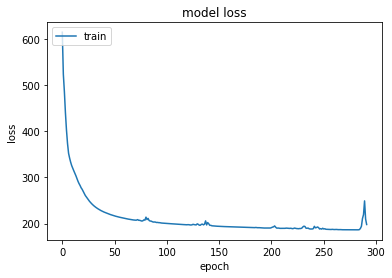

Epoch 1/500
2617/2617 [==============================] - 1s 380us/step - loss: 626.9974 - mean_absolute_error: 8.0382
Epoch 2/500
2617/2617 [==============================] - 0s 77us/step - loss: 536.8232 - mean_absolute_error: 7.6958
Epoch 3/500
2617/2617 [==============================] - 0s 81us/step - loss: 490.4549 - mean_absolute_error: 7.4929
Epoch 4/500
2617/2617 [==============================] - 0s 93us/step - loss: 445.7910 - mean_absolute_error: 7.2899
Epoch 5/500
2617/2617 [==============================] - 0s 68us/step - loss: 399.9848 - mean_absolute_error: 7.0905
Epoch 6/500
2617/2617 [==============================] - 0s 85us/step - loss: 372.9465 - mean_absolute_error: 6.9237
Epoch 7/500
2617/2617 [==============================] - 0s 76us/step - loss: 354.1878 - mean_absolute_error: 6.7683
Epoch 8/500
2617/2617 [==============================] - 0s 71us/step - loss: 342.7428 - mean_absolute_error: 6.6277
Epoch 9/500
2617/2617 [==============================] - 0s 70u

2617/2617 [==============================] - 0s 76us/step - loss: 211.0002 - mean_absolute_error: 4.1031
Epoch 71/500
2617/2617 [==============================] - 0s 74us/step - loss: 210.6211 - mean_absolute_error: 4.1046
Epoch 72/500
2617/2617 [==============================] - 0s 72us/step - loss: 210.5005 - mean_absolute_error: 4.1184
Epoch 73/500
2617/2617 [==============================] - 0s 84us/step - loss: 210.2880 - mean_absolute_error: 4.1215
Epoch 74/500
2617/2617 [==============================] - 0s 72us/step - loss: 209.9454 - mean_absolute_error: 4.1293
Epoch 75/500
2617/2617 [==============================] - 0s 80us/step - loss: 209.2998 - mean_absolute_error: 4.1188
Epoch 76/500
2617/2617 [==============================] - 0s 98us/step - loss: 208.9881 - mean_absolute_error: 4.1250
Epoch 77/500
2617/2617 [==============================] - 0s 79us/step - loss: 208.5657 - mean_absolute_error: 4.1223
Epoch 78/500
2617/2617 [==============================] - 0s 80us/ste

2617/2617 [==============================] - 0s 60us/step - loss: 200.6021 - mean_absolute_error: 4.1664
Epoch 140/500
2617/2617 [==============================] - 0s 74us/step - loss: 200.8216 - mean_absolute_error: 4.1741
Epoch 141/500
2617/2617 [==============================] - 0s 67us/step - loss: 202.5489 - mean_absolute_error: 4.1867
Epoch 142/500
2617/2617 [==============================] - 0s 69us/step - loss: 198.9457 - mean_absolute_error: 4.1463
Epoch 143/500
2617/2617 [==============================] - 0s 71us/step - loss: 200.6728 - mean_absolute_error: 4.1609
Epoch 144/500
2617/2617 [==============================] - 0s 87us/step - loss: 197.9508 - mean_absolute_error: 4.1252
Epoch 145/500
2617/2617 [==============================] - 0s 78us/step - loss: 198.1626 - mean_absolute_error: 4.1265
Epoch 146/500
2617/2617 [==============================] - 0s 72us/step - loss: 197.2918 - mean_absolute_error: 4.1116
Epoch 147/500
2617/2617 [==============================] - 0s 

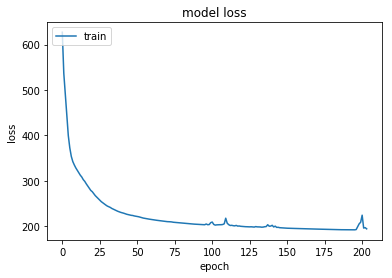

Epoch 1/500
2617/2617 [==============================] - 1s 365us/step - loss: 605.0786 - mean_absolute_error: 8.2627
Epoch 2/500
2617/2617 [==============================] - 0s 62us/step - loss: 514.4561 - mean_absolute_error: 7.9875
Epoch 3/500
2617/2617 [==============================] - 0s 67us/step - loss: 467.0345 - mean_absolute_error: 7.7530
Epoch 4/500
2617/2617 [==============================] - 0s 114us/step - loss: 425.5029 - mean_absolute_error: 7.5412
Epoch 5/500
2617/2617 [==============================] - 0s 83us/step - loss: 396.9975 - mean_absolute_error: 7.3575
Epoch 6/500
2617/2617 [==============================] - 0s 84us/step - loss: 373.6849 - mean_absolute_error: 7.1804
Epoch 7/500
2617/2617 [==============================] - 0s 86us/step - loss: 358.5245 - mean_absolute_error: 7.0127
Epoch 8/500
2617/2617 [==============================] - 0s 95us/step - loss: 347.3622 - mean_absolute_error: 6.8545
Epoch 9/500
2617/2617 [==============================] - 0s 10

2617/2617 [==============================] - 0s 77us/step - loss: 210.4610 - mean_absolute_error: 4.1346
Epoch 71/500
2617/2617 [==============================] - 0s 80us/step - loss: 210.6433 - mean_absolute_error: 4.1451
Epoch 72/500
2617/2617 [==============================] - 0s 77us/step - loss: 211.6174 - mean_absolute_error: 4.1704
Epoch 73/500
2617/2617 [==============================] - 0s 82us/step - loss: 210.4579 - mean_absolute_error: 4.1524
Epoch 74/500
2617/2617 [==============================] - ETA: 0s - loss: 222.3390 - mean_absolute_error: 4.239 - 0s 69us/step - loss: 221.3520 - mean_absolute_error: 4.2292
Epoch 75/500
2617/2617 [==============================] - 0s 71us/step - loss: 215.1091 - mean_absolute_error: 4.2212
Epoch 76/500
2617/2617 [==============================] - 0s 83us/step - loss: 210.5311 - mean_absolute_error: 4.1763
Epoch 77/500
2617/2617 [==============================] - 0s 72us/step - loss: 211.1043 - mean_absolute_error: 4.1807
Epoch 78/500


2617/2617 [==============================] - 0s 97us/step - loss: 197.1087 - mean_absolute_error: 4.1459
Epoch 139/500
2617/2617 [==============================] - 0s 80us/step - loss: 196.9998 - mean_absolute_error: 4.1424
Epoch 140/500
2617/2617 [==============================] - 0s 77us/step - loss: 196.8821 - mean_absolute_error: 4.1388
Epoch 141/500
2617/2617 [==============================] - 0s 64us/step - loss: 196.8015 - mean_absolute_error: 4.1354
Epoch 142/500
2617/2617 [==============================] - 0s 81us/step - loss: 196.7445 - mean_absolute_error: 4.1346
Epoch 143/500
2617/2617 [==============================] - 0s 70us/step - loss: 196.6803 - mean_absolute_error: 4.1309
Epoch 144/500
2617/2617 [==============================] - 0s 68us/step - loss: 196.8637 - mean_absolute_error: 4.1342
Epoch 145/500
2617/2617 [==============================] - 0s 82us/step - loss: 197.0555 - mean_absolute_error: 4.1339
Epoch 146/500
2617/2617 [==============================] - 0s 

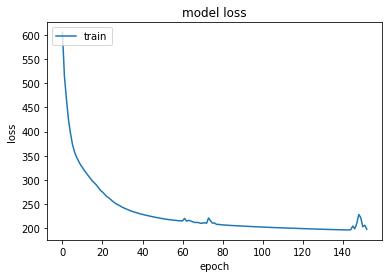

Epoch 1/500
2617/2617 [==============================] - 1s 370us/step - loss: 610.5295 - mean_absolute_error: 8.0711
Epoch 2/500
2617/2617 [==============================] - 0s 70us/step - loss: 525.7558 - mean_absolute_error: 7.8000
Epoch 3/500
2617/2617 [==============================] - 0s 74us/step - loss: 476.5905 - mean_absolute_error: 7.5912
Epoch 4/500
2617/2617 [==============================] - 0s 71us/step - loss: 444.6267 - mean_absolute_error: 7.4103
Epoch 5/500
2617/2617 [==============================] - 0s 71us/step - loss: 401.5897 - mean_absolute_error: 7.2014
Epoch 6/500
2617/2617 [==============================] - 0s 76us/step - loss: 380.0265 - mean_absolute_error: 7.0307
Epoch 7/500
2617/2617 [==============================] - 0s 79us/step - loss: 360.0410 - mean_absolute_error: 6.8717
Epoch 8/500
2617/2617 [==============================] - 0s 82us/step - loss: 346.8107 - mean_absolute_error: 6.7253
Epoch 9/500
2617/2617 [==============================] - 0s 77u

2617/2617 [==============================] - 0s 93us/step - loss: 210.4396 - mean_absolute_error: 4.1313
Epoch 71/500
2617/2617 [==============================] - 0s 78us/step - loss: 210.0752 - mean_absolute_error: 4.1331
Epoch 72/500
2617/2617 [==============================] - 0s 69us/step - loss: 209.6566 - mean_absolute_error: 4.1354
Epoch 73/500
2617/2617 [==============================] - 0s 73us/step - loss: 209.4057 - mean_absolute_error: 4.1407
Epoch 74/500
2617/2617 [==============================] - 0s 67us/step - loss: 209.4057 - mean_absolute_error: 4.1553
Epoch 75/500
2617/2617 [==============================] - ETA: 0s - loss: 210.9107 - mean_absolute_error: 4.179 - 0s 74us/step - loss: 209.9534 - mean_absolute_error: 4.1681
Epoch 76/500
2617/2617 [==============================] - 0s 66us/step - loss: 210.4162 - mean_absolute_error: 4.1911
Epoch 77/500
2617/2617 [==============================] - 0s 80us/step - loss: 210.2096 - mean_absolute_error: 4.1830
Epoch 78/500


2617/2617 [==============================] - 0s 89us/step - loss: 196.7350 - mean_absolute_error: 4.1278
Epoch 139/500
2617/2617 [==============================] - 0s 80us/step - loss: 196.6549 - mean_absolute_error: 4.1238
Epoch 140/500
2617/2617 [==============================] - 0s 67us/step - loss: 196.8750 - mean_absolute_error: 4.1278
Epoch 141/500
2617/2617 [==============================] - 0s 83us/step - loss: 196.6520 - mean_absolute_error: 4.1182
Epoch 142/500
2617/2617 [==============================] - 0s 82us/step - loss: 197.7010 - mean_absolute_error: 4.1324
Epoch 143/500
2617/2617 [==============================] - 0s 68us/step - loss: 196.8191 - mean_absolute_error: 4.1180
Epoch 144/500
2617/2617 [==============================] - 0s 86us/step - loss: 197.6084 - mean_absolute_error: 4.1262
Epoch 145/500
2617/2617 [==============================] - 0s 84us/step - loss: 197.4269 - mean_absolute_error: 4.1189
Epoch 146/500
2617/2617 [==============================] - 0s 

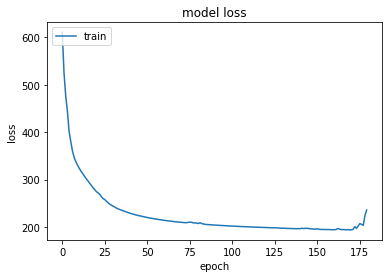

In [71]:
encod = []
original = []
compare = []
score = []
pre_start_date = '2015-01-01'
pre_end_date = '2016-01-01'
for i in range(len(df)):
    alpha, beta, gamma, delta = obtain_encoding(df[i], depts[i], sample_data, pre_end_date, pre_start_date, EPOCHS=500, BATCH_SIZE=500, DIM=50)
    encod.append(alpha)
    original.append(beta)
    compare.append(gamma)
    score.append(delta)
    encod[-1].to_csv('encoding_of_%s_customers.csv' %depts[i], index = False)
    original[-1].to_csv('original_of_%s_customers.csv' %depts[i], index = False)
    compare[-1].to_csv('comparison_of_%s_customers.csv' %depts[i], index = False)

In [72]:
print('Mean cosine distance:', np.mean(score))

Mean cosine distance: 0.49356002604177845
